### 9.2 Activity: Jupyter Notebook – Gradient Boost

For this week, include ideas such as gradient boost, learning rate, number of estimators, tree depth, and regularization. This homework should be submitted for peer review in the assignment titled 9.3 Peer Review: Week 9 Jupyter Notebook. Complete and submit your Jupyter Notebook homework by 11:59pm ET on Sunday. 

Ok the plan:
- Try a vanilla GBM on all 3 datasets, with some tuning
- Go ahead and drop in XGBoost Classifier and XGBoost Regressor and try some model tuning

In [1]:
! nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 5090 (UUID: GPU-f7f57dfb-5480-a1d6-1870-ac9f5f47ce36)


In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('scripts/play_surface/motion_train_X_resampled.csv')

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [12]:
# training sets
X_train = pd.read_csv('scripts/play_surface/motion_train_X_resampled.csv')
y_train = pd.read_csv('scripts/play_surface/motion_train_y_resampled.csv')['injured']

# holdout sets
X_holdout = pd.read_csv('scripts/play_surface/motion_holdout_X.csv')
y_holdout = pd.read_csv('scripts/play_surface/motion_holdout_y.csv')['injured']

import pandas as pd
import numpy as np

def create_lag_features_optimized(df):
    """Optimized lag feature creation - builds all features at once"""
    variables = ['dir', 'dis', 'o', 's', 'x', 'y']
    
    # Collect all new columns in a list first
    new_columns = {}
    
    for var in variables:
        cols = [f'{var}_slice_{i}' for i in range(10)]
        
        # Create lag features (previous time steps)
        for lag in [1, 2, 3]:
            for i in range(lag, 10):
                col_name = f'{var}_slice_{i}_lag{lag}'
                new_columns[col_name] = df[f'{var}_slice_{i-lag}'].values
        
        # Create lead features (future time steps)  
        for lead in [1, 2]:
            for i in range(10-lead):
                col_name = f'{var}_slice_{i}_lead{lead}'
                new_columns[col_name] = df[f'{var}_slice_{i+lead}'].values
    
    # Create new dataframe with all lag/lead features at once
    new_features_df = pd.DataFrame(new_columns, index=df.index)
    
    # Concatenate with original dataframe
    result_df = pd.concat([df, new_features_df], axis=1)
    
    return result_df

def create_time_series_features_optimized(df):
    """Optimized statistical time series feature creation"""
    variables = ['dir', 'dis', 'o', 's', 'x', 'y']

    # Collect all new features
    new_features = {}
    
    for var in variables:
        cols = [f'{var}_slice_{i}' for i in range(10)]
        
        # Get the data matrix for this variable (all time slices)
        data_matrix = df[cols].values
        
        # Compute all statistical features vectorized
        new_features[f'{var}_trend'] = np.nanmean(np.diff(data_matrix, axis=1), axis=1)
        new_features[f'{var}_slope'] = (data_matrix[:, -1] - data_matrix[:, 0]) / 9
        new_features[f'{var}_mean'] = np.nanmean(data_matrix, axis=1)
        new_features[f'{var}_std'] = np.nanstd(data_matrix, axis=1)
        new_features[f'{var}_min'] = np.nanmin(data_matrix, axis=1)
        new_features[f'{var}_max'] = np.nanmax(data_matrix, axis=1)
        new_features[f'{var}_range'] = new_features[f'{var}_max'] - new_features[f'{var}_min']
        
        # Change point features
        new_features[f'{var}_early_mean'] = np.nanmean(data_matrix[:, :3], axis=1)
        new_features[f'{var}_late_mean'] = np.nanmean(data_matrix[:, 7:], axis=1)
        new_features[f'{var}_early_late_diff'] = new_features[f'{var}_late_mean'] - new_features[f'{var}_early_mean']
        
        # Volatility features
        new_features[f'{var}_volatility'] = np.nanstd(np.diff(data_matrix, axis=1), axis=1)
        
        # Pattern recognition features
        diff_matrix = np.diff(data_matrix, axis=1)
        new_features[f'{var}_monotonic_increase'] = np.sum(diff_matrix > 0, axis=1)
        new_features[f'{var}_monotonic_decrease'] = np.sum(diff_matrix < 0, axis=1)
        
        # Direction changes (second derivative)
        second_diff = np.diff(diff_matrix, axis=1)
        new_features[f'{var}_direction_changes'] = np.sum(second_diff != 0, axis=1)
        
        # Coefficient of variation (handle division by zero)
        means = new_features[f'{var}_mean']
        stds = new_features[f'{var}_std']
        new_features[f'{var}_coefficient_variation'] = np.where(
            np.abs(means) > 1e-8, 
            stds / np.abs(means), 
            0
        )
        
        # Time-weighted features (recent values matter more)
        weights = np.arange(1, 11)  # 1, 2, 3, ..., 10
        weighted_sum = np.sum(data_matrix * weights, axis=1)
        new_features[f'{var}_weighted_mean'] = weighted_sum / np.sum(weights)
    
    # Create dataframe from all new features
    new_features_df = pd.DataFrame(new_features, index=df.index)
    
    # Concatenate with original
    result_df = pd.concat([df, new_features_df], axis=1)
    
    return result_df

def create_interaction_features_optimized(df):
    """Optimized interaction feature creation"""
    new_features = {}
    
    # Cross-variable interactions at each time slice
    for i in range(10):
        new_features[f'x_y_interaction_{i}'] = df[f'x_slice_{i}'] * df[f'y_slice_{i}']
        new_features[f'dis_o_interaction_{i}'] = df[f'dis_slice_{i}'] * df[f'o_slice_{i}']
        
        # Distance-like features
        new_features[f'euclidean_distance_{i}'] = np.sqrt(
            df[f'x_slice_{i}']**2 + df[f'y_slice_{i}']**2
        )
        
        # Angle-like features (if o represents orientation)
        new_features[f'velocity_x_{i}'] = df[f'dis_slice_{i}'] * np.cos(df[f'o_slice_{i}'])
        new_features[f'velocity_y_{i}'] = df[f'dis_slice_{i}'] * np.sin(df[f'o_slice_{i}'])
    
    # Multi-variable aggregate features
    x_cols = [f'x_slice_{i}' for i in range(10)]
    y_cols = [f'y_slice_{i}' for i in range(10)]
    dis_cols = [f'dis_slice_{i}' for i in range(10)]
    
    # Total displacement path
    x_data = df[x_cols].values
    y_data = df[y_cols].values
    
    new_features['total_displacement'] = np.sqrt(
        (x_data[:, -1] - x_data[:, 0])**2 + 
        (y_data[:, -1] - y_data[:, 0])**2
    )
    
    # Path efficiency (straight line vs actual path)
    total_distance = np.sum(df[dis_cols].values, axis=1)
    new_features['path_efficiency'] = np.where(
        total_distance > 1e-8,
        new_features['total_displacement'] / total_distance,
        0
    )
    
    # Create dataframe and concatenate
    new_features_df = pd.DataFrame(new_features, index=df.index)
    result_df = pd.concat([df, new_features_df], axis=1)
    
    return result_df

def create_all_time_series_features(df):
    """Create all time series features efficiently"""
    print("Creating lag/lead features...")
    df = create_lag_features_optimized(df)
    
    print("Creating statistical features...")
    df = create_time_series_features_optimized(df)
    
    print("Creating interaction features...")
    df = create_interaction_features_optimized(df)
    
    # Defragment the dataframe
    print("Defragmenting dataframe...")
    df = df.copy()
    
    print(f"Final shape: {df.shape}")
    return df

# Usage:
# df_enhanced = create_all_time_series_features(df)
# 
# This will be much faster and won't generate performance warnings!

X_train = create_all_time_series_features(X_train)
X_holdout = create_all_time_series_features(X_holdout)

Creating lag/lead features...
Creating statistical features...
Creating interaction features...
Defragmenting dataframe...
Final shape: (9130, 477)
Creating lag/lead features...
Creating statistical features...
Creating interaction features...
Defragmenting dataframe...
Final shape: (53392, 477)


/tmp/ipykernel_22130/3885097112.py:86: RuntimeWarning: invalid value encountered in divide
  stds / np.abs(means),
/tmp/ipykernel_22130/3885097112.py:86: RuntimeWarning: invalid value encountered in divide
  stds / np.abs(means),
/tmp/ipykernel_22130/3885097112.py:139: RuntimeWarning: divide by zero encountered in divide
  new_features['total_displacement'] / total_distance,


In [14]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix as conf_matrix, roc_auc_score, log_loss
import numpy as np
import pandas as pd

def diagnose_and_train_xgboost_classifier(X, y, use_time_split=False, test_size=0.2):
    """
    Comprehensive XGBoost CLASSIFICATION training with diagnostics
    
    Parameters:
    -----------
    X : DataFrame - Features
    y : Series/array - Target variable (class labels)
    use_time_split : bool - Whether to use TimeSeriesSplit (only if rows are temporally ordered)
    test_size : float - Test set proportion
    """
    
    print("=== DATA DIAGNOSTICS ===")
    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    print(f"Target classes and counts:")
    print(pd.Series(y).value_counts().sort_index())
    print(f"Class balance:")
    for class_val in sorted(pd.Series(y).unique()):
        prop = (pd.Series(y) == class_val).mean()
        print(f"  Class {class_val}: {prop:.3f} ({prop*100:.1f}%)")
    
    # Determine if binary or multiclass
    n_classes = len(pd.Series(y).unique())
    is_binary = n_classes == 2
    print(f"Number of classes: {n_classes}")
    print(f"Problem type: {'Binary' if is_binary else 'Multiclass'} Classification")
    
    # Split data
    if use_time_split:
        print("\n=== USING TIME SERIES SPLIT ===")
        # For actual time series data where row order matters
        split_point = int(len(X) * (1 - test_size))
        X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
        y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]
        cv_method = TimeSeriesSplit(n_splits=5)
    else:
        print("\n=== USING RANDOM SPLIT ===")
        # For independent sequences (more likely for your data)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )
        cv_method = 5  # Regular 5-fold CV
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # XGBoost parameters for classification
    if is_binary:
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'max_depth': 4,
            'learning_rate': 0.1,
            'n_estimators': 500,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'reg_alpha': 0.1,
            'reg_lambda': 0.1,
            'random_state': 42,
            'device': 'cuda',      # GPU acceleration
            'tree_method': 'hist', # Required for GPU
            'n_jobs': 1           # Use 1 job when using GPU
        }
        model = xgb.XGBClassifier(**params)
    else:
        params = {
            'objective': 'multi:softprob',
            'eval_metric': 'mlogloss',
            'max_depth': 4,
            'learning_rate': 0.1,
            'n_estimators': 500,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'reg_alpha': 0.1,
            'reg_lambda': 0.1,
            'random_state': 42,
            'device': 'cuda',      # GPU acceleration
            'tree_method': 'hist', # Required for GPU
            'n_jobs': 1           # Use 1 job when using GPU
        }
        model = xgb.XGBClassifier(**params)
    
    print("\n=== MODEL TRAINING ===")
    
    # Cross-validation with appropriate scoring
    scoring_metric = 'roc_auc' if is_binary else 'accuracy'
    
    if use_time_split:
        cv_scores = []
        for train_idx, val_idx in cv_method.split(X_train):
            X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            temp_model = xgb.XGBClassifier(**params)
            temp_model.fit(X_cv_train, y_cv_train, verbose=False)
            
            if is_binary:
                y_pred_proba = temp_model.predict_proba(X_cv_val)[:, 1]
                score = roc_auc_score(y_cv_val, y_pred_proba)
            else:
                score = temp_model.score(X_cv_val, y_cv_val)
            cv_scores.append(score)
    else:
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv_method, scoring=scoring_metric)
    
    print(f"Cross-validation {scoring_metric} scores: {cv_scores}")
    print(f"Mean CV {scoring_metric}: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")
    
    # Train final model
    model.fit(X_train, y_train, verbose=False)
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    if is_binary:
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba_train = model.predict_proba(X_train)
        y_pred_proba_test = model.predict_proba(X_test)
    
    print("\n=== EVALUATION METRICS ===")
    print("Training Set:")
    print(f"  Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
    if is_binary:
        print(f"  AUC-ROC: {roc_auc_score(y_train, y_pred_proba_train):.4f}")
        print(f"  Log Loss: {log_loss(y_train, y_pred_proba_train):.4f}")
    else:
        print(f"  Log Loss: {log_loss(y_train, y_pred_proba_train):.4f}")
    
    print("\nTest Set:")
    print(f"  Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
    if is_binary:
        print(f"  AUC-ROC: {roc_auc_score(y_test, y_pred_proba_test):.4f}")
        print(f"  Log Loss: {log_loss(y_test, y_pred_proba_test):.4f}")
    else:
        print(f"  Log Loss: {log_loss(y_test, y_pred_proba_test):.4f}")
    
    print("\n=== CLASSIFICATION REPORT ===")
    print(classification_report(y_test, y_pred_test))
    
    print("\n=== CONFUSION MATRIX ===")
    cm = conf_matrix(y_test, y_pred_test)
    print(cm)
    
    # Feature importance
    print("\n=== TOP 10 FEATURE IMPORTANCES ===")
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(feature_importance.head(10))
    
    # Baseline comparison
    majority_class = pd.Series(y_train).mode()[0]
    baseline_accuracy = (pd.Series(y_test) == majority_class).mean()
    
    print(f"\n=== BASELINE COMPARISON ===")
    print(f"Baseline accuracy (majority class): {baseline_accuracy:.4f}")
    print(f"Model improvement over baseline: {accuracy_score(y_test, y_pred_test) - baseline_accuracy:.4f}")
    
    return model, {
        'cv_scores': cv_scores,
        'test_accuracy': accuracy_score(y_test, y_pred_test),
        'test_auc': roc_auc_score(y_test, y_pred_proba_test) if is_binary else None,
        'test_logloss': log_loss(y_test, y_pred_proba_test),
        'feature_importance': feature_importance,
        'classification_report': classification_report(y_test, y_pred_test, output_dict=True),
        'confusion_matrix': conf_matrix(y_test, y_pred_test),
        'y_pred_test': y_pred_test,
        'y_pred_proba_test': y_pred_proba_test,
        'y_test': y_test
    }

# Alternative: Simple baseline models for comparison
def test_baseline_classifiers(X, y):
    """Test simple baseline classification models"""
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.dummy import DummyClassifier
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Majority Class': DummyClassifier(strategy='most_frequent'),
        'Stratified': DummyClassifier(strategy='stratified', random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        results[name] = accuracy
        print(f"{name}: Accuracy = {accuracy:.4f}")
    
    return results

# Usage examples:
# model, results = diagnose_and_train_xgboost_classifier(X, y, use_time_split=False)
# baseline_results = test_baseline_classifiers(X, y)

In [18]:
model, results = diagnose_and_train_xgboost_classifier(X_train, y_train.ravel(), use_time_split=False)

/tmp/ipykernel_22130/4162151118.py:1: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model, results = diagnose_and_train_xgboost_classifier(X_train, y_train.ravel(), use_time_split=False)


=== DATA DIAGNOSTICS ===
Features shape: (9130, 477)
Target shape: (9130,)
Target classes and counts:
0.0    8300
1.0     830
Name: count, dtype: int64
Class balance:
  Class 0.0: 0.909 (90.9%)
  Class 1.0: 0.091 (9.1%)
Number of classes: 2
Problem type: Binary Classification

=== USING RANDOM SPLIT ===
Training set: 7304 samples
Test set: 1826 samples

=== MODEL TRAINING ===
Cross-validation roc_auc scores: [0.99856921 0.99812596 0.9977806  0.99755979 0.99831143]
Mean CV roc_auc: 0.9981 (+/- 0.0007)

=== EVALUATION METRICS ===
Training Set:
  Accuracy: 1.0000
  AUC-ROC: 1.0000
  Log Loss: 0.0015

Test Set:
  Accuracy: 0.9929
  AUC-ROC: 0.9991
  Log Loss: 0.0212

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      1659
         1.0       1.00      0.92      0.96       167

    accuracy                           0.99      1826
   macro avg       1.00      0.96      0.98      1826
weighted avg       0.99   

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_holdout_scaled = scaler.fit_transform(X_holdout)

y_holdout_pred = model.predict(X_holdout_scaled)
y_holdout_pred_proba = model.predict_proba(X_holdout_scaled)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score, log_loss, confusion_matrix as conf_matrix

print("Classification Report:")
print(classification_report(y_holdout, y_holdout_pred))

print("ROC AUC Score:")
print(roc_auc_score(y_holdout, y_holdout_pred_proba))

print("Log Loss:")
print(log_loss(y_holdout, y_holdout_pred_proba))

print("Confusion Matrix:")
print(conf_matrix(y_holdout, y_holdout_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96     53371
         1.0       0.00      0.10      0.00        21

    accuracy                           0.93     53392
   macro avg       0.50      0.51      0.48     53392
weighted avg       1.00      0.93      0.96     53392

ROC AUC Score:
0.5699804869953452
Log Loss:
0.16693435180738594
Confusion Matrix:
[[49778  3593]
 [   19     2]]


In [24]:
# Compare feature distributions
print("Training data feature means:")
print(X_train.mean())
print("\nHoldout data feature means:")
print(X_holdout_scaled.mean())

# Check for significant differences
from scipy.stats import ks_2samp
for col in X_train.columns:
    stat, p_value = ks_2samp(X_train[col], X_holdout[col])
    if p_value < 0.01:
        print(f"Significant difference in {col}: p={p_value:.6f}")

Training data feature means:
dir_slice_0            -0.020542
dir_slice_1            -0.004256
dir_slice_2            -0.009954
dir_slice_3            -0.000207
dir_slice_4             0.016740
                          ...   
euclidean_distance_9    1.251630
velocity_x_9           -0.015801
velocity_y_9            0.006444
total_displacement      1.073746
path_efficiency         1.423568
Length: 477, dtype: float64

Holdout data feature means:
3.500822934519567e-17
Significant difference in dir_slice_0: p=0.000000
Significant difference in dir_slice_1: p=0.000000
Significant difference in dir_slice_2: p=0.000000
Significant difference in dir_slice_3: p=0.000000
Significant difference in dir_slice_4: p=0.000000
Significant difference in dir_slice_5: p=0.000000
Significant difference in dir_slice_6: p=0.000000
Significant difference in dir_slice_7: p=0.000000
Significant difference in dir_slice_8: p=0.000000
Significant difference in dir_slice_9: p=0.000000
Significant difference in dis

### try again with our resampled dataset

[0]	validation_0-auc:0.91537
[1]	validation_0-auc:0.94467
[2]	validation_0-auc:0.95298
[3]	validation_0-auc:0.97536
[4]	validation_0-auc:0.97302
[5]	validation_0-auc:0.96835
[6]	validation_0-auc:0.97498
[7]	validation_0-auc:0.97734
[8]	validation_0-auc:0.97602
[9]	validation_0-auc:0.97890
[10]	validation_0-auc:0.98586
[11]	validation_0-auc:0.98516
[12]	validation_0-auc:0.98318
[13]	validation_0-auc:0.98532
[14]	validation_0-auc:0.98668
[15]	validation_0-auc:0.98608
[16]	validation_0-auc:0.98684
[17]	validation_0-auc:0.98738
[18]	validation_0-auc:0.98667
[19]	validation_0-auc:0.98828
[20]	validation_0-auc:0.98735
[21]	validation_0-auc:0.98835
[22]	validation_0-auc:0.98979
[23]	validation_0-auc:0.98882
[24]	validation_0-auc:0.98898
[25]	validation_0-auc:0.98893
[26]	validation_0-auc:0.98900
[27]	validation_0-auc:0.98803
[28]	validation_0-auc:0.98755
[29]	validation_0-auc:0.98791
[30]	validation_0-auc:0.98837
[31]	validation_0-auc:0.98782
[32]	validation_0-auc:0.98806
[33]	validation_0-au

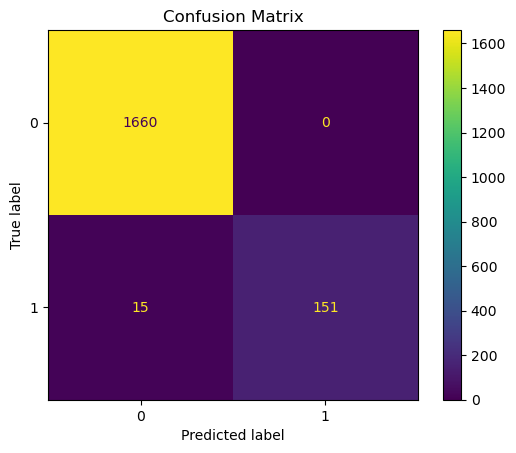

In [6]:
# 6. Define the XGBoost model
model = XGBClassifier(
    n_estimators=500,
    objective='binary:logistic',
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    device='cuda',        # Use GPU acceleration
    eval_metric='auc'   # Handle imbalance
)

# 7. Train the model
model.fit(
    X_param_train,
    y_param_train,
    eval_set=[(X_param_val, y_param_val)],
    verbose=True
)

# 8. Predict and evaluate
y_pred = model.predict(X_param_val)
y_pred_proba = model.predict_proba(X_param_val)[:, 1]

# Classification report
print(classification_report(y_param_val, y_pred))

# AUC score
auc = roc_auc_score(y_param_val, y_pred_proba)
print(f"AUC Score: {auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_param_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

Initial results are pretty good for an untuned model: we've greatly reduced the False Positive Rate over the other models without losing any accuracy. Using the confusion matrix and AUC as my preferred evaluation metrics, let's try some tuning:

In [8]:
learning_rates = [0.01, 0.03, 0.05, 0.1]
results = []

for lr in learning_rates:
    model = XGBClassifier(
        n_estimators=500,
        objective='binary:logistic',
        learning_rate=lr,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        device='cuda',
        eval_metric='auc',
        scale_pos_weight=pos_weight
    )
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    results.append((lr, auc))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in results], [x[1] for x in results], marker='o')
plt.title('AUC Score vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('AUC Score')
plt.xticks(learning_rates)
plt.grid()
plt.show()

NameError: name 'pos_weight' is not defined

The various LR values don't seem to have a meaningful impact on the AUC score, dropping off slightly but then rebounding as we hit the end of the loop. 

In [ ]:
max_depths = [3, 4, 5, 6, 7, 8, 9, 10]
results_depth = []

for depth in max_depths:
    model = XGBClassifier(
        n_estimators=500,
        objective='binary:logistic',
        learning_rate=0.03,
        max_depth=depth,
        subsample=0.8,
        colsample_bytree=0.8,
        device='cuda',
        eval_metric='auc',
        scale_pos_weight=pos_weight
    )
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    results_depth.append((depth, auc))
    best_depth = depth if auc == max([x[1] for x in results_depth]) else best_depth


best_model = XGBClassifier(
    n_estimators=500,
    objective='binary:logistic',
    learning_rate=0.03,
    max_depth=best_depth,
    subsample=0.8,
    colsample_bytree=0.8,
    device='cuda',
    eval_metric='auc',
    scale_pos_weight=pos_weight
)
best_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in results_depth], [x[1] for x in results_depth], marker='o')
plt.title('AUC Score vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('AUC Score')
plt.xticks(max_depths)
plt.grid()
plt.show()

Max Depth is a little more interesting. Here the shallower models perform significantly better on the test set, suggesting that the model is overfitting when tree depth is increased. 

In [ ]:
subsample_rates = [0.5, 0.6, 0.7, 0.8, 0.9]
results_subsample = []

for rate in subsample_rates:
    model = XGBClassifier(
        n_estimators=500,
        objective='binary:logistic',
        learning_rate=0.03,
        max_depth=best_depth,
        subsample=rate,
        colsample_bytree=0.8,
        device='cuda',
        eval_metric='auc',
        scale_pos_weight=pos_weight
    )
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    results_subsample.append((rate, auc))

# print classification report for best subsample rate
best_subsample_rate = max(results_subsample, key=lambda x: x[1])[0]
best_model = XGBClassifier(
    n_estimators=500,
    objective='binary:logistic',
    learning_rate=0.03,
    max_depth=best_depth,
    subsample=best_subsample_rate,
    colsample_bytree=0.8,
    device='cuda',
    eval_metric='auc',
    scale_pos_weight=pos_weight
)
best_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in results_subsample], [x[1] for x in results_subsample], marker='o')
plt.title('AUC Score vs Subsample Rate')
plt.xlabel('Subsample Rate')
plt.ylabel('AUC Score')
plt.xticks(subsample_rates)
plt.grid()
plt.show()

The subsample rate will adjust the Fraction of rows sampled per tree. Values < 1.0 add randomness and reduce overfitting. This is another Regularization technique to confol overfitting. Looks like .8 is the sweetspot here. 

Now let's put it all together with our best model:

In [ ]:
best_model = XGBClassifier(
    n_estimators=500,
    objective='binary:logistic',
    learning_rate=0.03,
    max_depth=best_depth,
    subsample=best_subsample_rate,
    colsample_bytree=0.8,
    device='cuda',
    eval_metric='auc',
    scale_pos_weight=pos_weight
)
best_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Next, onto our 2nd classification set:

In [ ]:
df = pd.read_csv('/home/pshmo/ai4l_final_project_2/ai4l_final_project/datasets/NFL-Punt-Analytics-Competition/processed_punt_data.csv')
# Get boolean columns
boolean_columns = df.select_dtypes(include='bool').columns

# Convert boolean columns to integers (True -> 1, False -> 0)
for col in boolean_columns:
    df[col] = df[col].astype(int)

# Display the first few rows to verify the conversion
print("Boolean columns converted to integers:")
print(df[boolean_columns].head())
df = df.drop(columns=['season_year', 'gamekey', 'playid', 'gsisid'])

# create X and y
X = df.drop(columns=['injury'])
y = df['injury']

# Split into train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
)

For fun, let's try our best parameters from the previous model and see what we get:

In [ ]:
from sklearn.metrics import confusion_matrix

# compute class imbalance weight: 
pos_weight = (len(y) - sum(y)) / sum(y)

# fit a basic xgboost classifier
model = XGBClassifier(
    n_estimators=500,
    objective='binary:logistic',
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    device='cuda',
    eval_metric='auc',
    scale_pos_weight=pos_weight
)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
disp.plot()
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_test, y_pred))

Now we're getting somewhere: this is the best classification score I've ever pulled on this dataset. Let's try our tuning:

In [ ]:
n_estimators = [100, 200, 300, 400, 500]
results_n_estimators = []
for n in n_estimators:
    model = XGBClassifier(
        n_estimators=n,
        objective='binary:logistic',
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        device='cuda',
        eval_metric='auc',
        scale_pos_weight=pos_weight
    )
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    results_n_estimators.append((n, auc))
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in results_n_estimators], [x[1] for x in results_n_estimators], marker='o')
plt.title('AUC Score vs Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('AUC Score')
plt.xticks(n_estimators)
plt.grid()
plt.show()

In [ ]:
learning_rates = [0.01, 0.03, 0.05, 0.1]
results_lr = []
for lr in learning_rates:
    model = XGBClassifier(
        n_estimators=200,
        objective='binary:logistic',
        learning_rate=lr,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        device='cuda',
        eval_metric='auc',
        scale_pos_weight=pos_weight
    )
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    results_lr.append((lr, auc))
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in results_lr], [x[1] for x in results_lr], marker='o')
plt.title('AUC Score vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('AUC Score')
plt.xticks(learning_rates)
plt.grid()
plt.show()

In [ ]:
max_depths = [3, 4, 5, 6, 7, 8, 9, 10]
results_max_depth = []
for depth in max_depths:
    model = XGBClassifier(
        n_estimators=200,
        objective='binary:logistic',
        learning_rate=0.1,
        max_depth=depth,
        subsample=0.8,
        colsample_bytree=0.8,
        device='cuda',
        eval_metric='auc',
        scale_pos_weight=pos_weight
    )
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    results_max_depth.append((depth, auc))
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in results_max_depth], [x[1] for x in results_max_depth], marker='o')
plt.title('AUC Score vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('AUC Score')
plt.xticks(max_depths)
plt.grid()
plt.show()

In [ ]:
subsample_rates = [0.5, 0.6, 0.7, 0.8, 0.9]
results_subsample = []
for rate in subsample_rates:
    model = XGBClassifier(
        n_estimators=200,
        objective='binary:logistic',
        learning_rate=0.1,
        max_depth=7,
        subsample=rate,
        colsample_bytree=0.8,
        device='cuda',
        eval_metric='auc',
        scale_pos_weight=pos_weight
    )
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    results_subsample.append((rate, auc))
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in results_subsample], [x[1] for x in results_subsample], marker='o')
plt.title('AUC Score vs Subsample Rate')
plt.xlabel('Subsample Rate')
plt.ylabel('AUC Score')
plt.xticks(subsample_rates)
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
best_model = XGBClassifier(
    n_estimators=200,
    objective='binary:logistic',
    learning_rate=0.1,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    device='cuda',
    eval_metric='auc',
    scale_pos_weight=pos_weight
)
best_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_pred = best_model.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
disp.plot()
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_test, y_pred))
print(f"Best Model AUC: {roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]):.4f}")
print(f"Best Model Parameters: {best_model.get_params()}")

Not a lot of movement on the confusion matrix (we've managed to remove the one false positive). All in all we've got a pretty good set of evidence to suggest that gradient boosting is a strong candidate for model selection (I'm still working on getting the full time series represntation working)